# 0. Import librairies

Import the librairies

In [71]:
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objects as go
import IPython.display as display
from IPython.display import Markdown
from kaleido.scopes.plotly import PlotlyScope
from wordcloud import WordCloud, ImageColorGenerator
from plotly.subplots import make_subplots

In [72]:
# Function to save or show a figure

# GLOBAL VARIABLE: display_option = "static" or "dynamic"
DISPLAY_OPTION = "static" #for github mainly
#DISPLAY_OPTION = "dynamic" #for interactive display  

def save_or_show_figure(fig, filename, format="svg", display_option=DISPLAY_OPTION):
    scope = PlotlyScope(
        plotlyjs="https://cdn.plot.ly/plotly-latest.min.js",
    )

    if format == "svg":
        with open(filename, "wb") as f:
            f.write(scope.transform(fig, format="svg"))
    else:
        fig.write_image(filename)

    if display_option == "static":
        return Markdown("""![{filename}]({filename})""".format(filename=filename))
    else:
        return fig.show()

Import the datasets

In [107]:
PATH_IN = './MovieSummaries/'

def OpenDf(PATH) :
    '''
    This function opens the dataframes stored in the file with location PATH
    '''
    
    character_file = os.path.join(PATH_IN, 'character.metadata.tsv')
    movie_file = os.path.join(PATH_IN, 'movie.metadata.tsv')
    name_file = os.path.join(PATH_IN, 'name.clusters.txt')
    plot_file = os.path.join(PATH_IN, 'plot_summaries.txt')
    tvtrop_file = os.path.join(PATH_IN, 'tvtropes.clusters.txt')

    movie_col= ["Wikipedia movie ID","Freebase movie ID","Movie name","Movie release date",
                 "Movie box office revenue","Movie runtime","Movie languages","Movie countries",
                 "Movie genres"]

    character_col = ["Wikipedia movie ID","Freebase movie ID","Movie release date","Character Name","Actor DOB",
             "Actor gender","Actor height","Actor ethnicity","Actor Name",
             "Actor age at movie release","Freebase character map"]
    name_col = ["Character Name","Freebase character map ?"]

    plot_col = ["Wikipedia movie ID","Plot"]

    characterDF = pd.read_table(character_file,names=character_col,index_col=False)
    movieDF = pd.read_table(movie_file,names=movie_col,index_col=False)
    nameDF = pd.read_csv(name_file, sep="\t",names=name_col,index_col=False)
    plotDF = pd.read_csv(plot_file, sep="\t",names=plot_col,index_col=False)

    tvtrop_f = open(tvtrop_file)
    lines = tvtrop_f.readlines()
    tvtrop_f.close()
    tvtropDF = pd.DataFrame(columns=["stereotype","char","movie","id","actor"])
    for line in lines:
        char_type,dico = line.split("\t")
        dico = json.loads(dico)
        dico["stereotype"] = char_type
        tvtropDF = pd.concat([tvtropDF,pd.DataFrame([dico])],ignore_index=True)
        
    return characterDF,movieDF,nameDF,plotDF,tvtropDF

characterDF,movieDF,nameDF,plotDF,tvtropDF = OpenDf(PATH_IN)

C:\Users\paul\AppData\Local\Temp\ipykernel_30860\2810662041.py:25: ParserWarning:

Length of header or names does not match length of data. This leads to a loss of data with index_col=False.



# 1. Building a ‘robot portrait’ of human beings thanks to the CMU dataset, and comparing it to reality

# 2. Influence of movies on society, and vice-versa

### 2 a. Adding real babies names dataset and comparing temporal frequencies between reality and fiction (consider only the 100 most famous movies)

##### Study on the top 100 movies

In [70]:
print("Percentage of movie with nan in movie box office revenue: {:.2f}%".format(movieDF["Movie box office revenue"].isna().sum()/len(movieDF)*100))
print("Number of movie with nan in movie box office revenue: {} out of {}".format(movieDF["Movie box office revenue"].isna().sum(),len(movieDF)))

fig = go.Figure(go.Bar(
    x=movieDF.dropna(subset=["Movie box office revenue"]).sort_values(by="Movie box office revenue",ascending=True).tail(100)["Movie box office revenue"], 
    y=movieDF.dropna(subset=["Movie box office revenue"]).sort_values(by="Movie box office revenue",ascending=True).tail(100)["Movie name"], 
    orientation='h',
    text=movieDF.dropna(subset=["Movie box office revenue"]).sort_values(by="Movie box office revenue",ascending=True).tail(100)["Movie box office revenue"],
    textposition='outside'
))

fig.update_layout(
    height=2000,
    xaxis_title="Box Office Revenue ($)",
    yaxis_title="Movie Name",
    title="Top 100 Movies by Box Office Revenue",
    plot_bgcolor='rgba(0,0,0,0)'
)

save_or_show_figure(fig, "img/Top100movies.svg")

Percentage of movie with nan in movie box office revenue: 89.72%
Number of movie with nan in movie box office revenue: 73340 out of 81741


![img/Top100movies.svg](img/Top100movies.svg)

Wordcloud of the top100 movie names

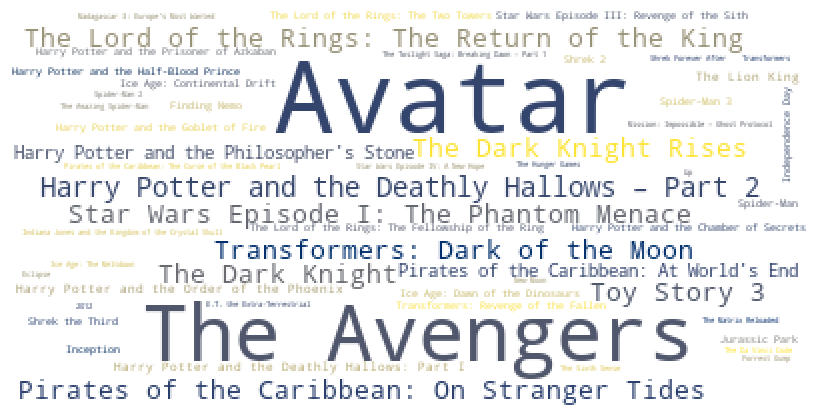

In [75]:
# Drop rows with missing values in the "Movie box office revenue" column
movieDF_cleaned = movieDF.dropna(subset=["Movie box office revenue"])

# Create a dictionary with movie names as keys and their box office revenue as values
movie_name_revenue_dict = dict(zip(movieDF_cleaned["Movie name"], movieDF_cleaned["Movie box office revenue"]))

# Generate the word cloud from the movie names and their box office revenue
wordcloud = WordCloud(
    max_font_size=50,
    background_color="white",
    colormap="cividis",
).generate_from_frequencies(movie_name_revenue_dict)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

##### Study on the characters present in the top 100 movies

Import the babyname dataset in the US

In [76]:
# we will extract only the characters from the top 100 movies in the dataset based movieDF["Movie box office revenue"]
top100_characters = characterDF[characterDF["Wikipedia movie ID"].isin(movieDF.sort_values(by="Movie box office revenue",ascending=False)["Wikipedia movie ID"].head(100))]

PATH_IN = './Name/'

def OpenNameDf(PATH) :
    '''
    This function opens the dataframes stored in the file with location PATH
    '''
    
    #for all file present in the folder
    files = os.listdir(PATH)
    baby_nameDF = pd.DataFrame()
    
    for file in files:
        if file.endswith(".txt"):
            name_file = os.path.join(PATH, file)
            # name_col = ["Firstname","Sexe","Number"]
            name_a_yearDF = pd.read_table(name_file, sep=",",index_col=False)
            name_a_yearDF = name_a_yearDF.drop_duplicates()
            name_a_yearDF = name_a_yearDF.drop(name_a_yearDF[name_a_yearDF["Firstname"]=="Firstname"].index)
            #add a column for the year given in the filename
            name_a_yearDF["Year"] = file.split(".")[0].replace("yob","")
            name_a_yearDF.to_csv(os.path.join(PATH_IN, file),index=False)
            
            # Concatenate the new data with the existing data
            baby_nameDF = pd.concat([baby_nameDF, name_a_yearDF])
        
    return baby_nameDF

baby_nameDF = OpenNameDf(PATH_IN)

In [77]:
# Create a set of valid first names from baby_nameDF["Firstname"]
valid_firstnames = set(baby_nameDF["Firstname"])

# Group and aggregate the data to calculate total occurrences by name
name_occurrences = baby_nameDF[baby_nameDF["Firstname"].isin(valid_firstnames)].groupby("Firstname")["Number"].sum().reset_index()


# Create a dictionary that maps first names to their total occurrences
name_occurrences_dict = dict(zip(name_occurrences["Firstname"], name_occurrences["Number"]))

# Define a function to extract the top firstname
def extract_top_firstname(name):
    if isinstance(name, str):
        names = name.split()
        firstnames = [n for n in names if n in valid_firstnames]
        if firstnames:
            top_firstname = max(firstnames, key=lambda n: name_occurrences_dict.get(n, 0))
            return top_firstname
    return None

# Apply the function to the "Character Name" column
top100_characters["Character firstname"] = top100_characters["Character Name"].apply(extract_top_firstname)

# Drop rows where "Character firstname" is NaN
top100_characters.dropna(subset=["Character firstname"], inplace=True)

#count number of unique name in top100
print("Number of unique name in top100 : ",len(top100_characters["Character firstname"].unique()))

# to name_occurences, add the column "First year appearance"
name_occurrences["First year appearance"] = baby_nameDF[baby_nameDF["Firstname"].isin(valid_firstnames)].groupby("Firstname")["Year"].min().reset_index()["Year"]

# Convert "Movie release Date" to a datetime object and extract the year
top100_characters["Year"] = pd.to_datetime(top100_characters["Movie release date"]).dt.year

C:\Users\paul\AppData\Local\Temp\ipykernel_30860\3864172068.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\paul\AppData\Local\Temp\ipykernel_30860\3864172068.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of unique name in top100 :  830


C:\Users\paul\AppData\Local\Temp\ipykernel_30860\3864172068.py:34: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### Study on the babies firstname recensed in the US after their presence in a movie

A first simple study could be to see if new firstname ermarged after the apparition of a movie. This doesn't conclude wether the movie created this firstname or not, but the event could be correlated.

Number of names with their films where the name wasn't present before the film in name_occurrences: 84


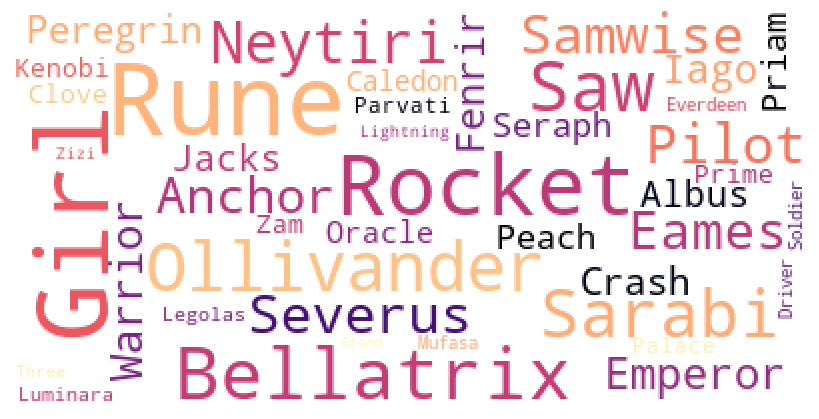

In [78]:
# Merge the DataFrames on the "Firstname" column
merged_data = top100_characters.merge(name_occurrences, left_on="Character firstname", right_on="Firstname", how="left")

# Convert the "First year appearance" and "Year" columns to integers
merged_data["First year appearance"] = merged_data["First year appearance"].astype(int)
merged_data["Year"] = merged_data["Year"].astype(int)

# Filter the rows where "First year appearance" is greater than "Year"
filtered_data = merged_data[merged_data["First year appearance"] > merged_data["Year"]]

# Calculate the number of names and their films
num_names_with_films = len(filtered_data)

# Print the result
print("Number of names with their films where the name wasn't present before the film in name_occurrences:", num_names_with_films)

# Generate the word cloud with a specific colormap (e.g., 'viridis')
wordcloud = WordCloud(
    max_font_size=50,
    max_words=100,
    background_color="white",
    colormap='magma'
).generate_from_frequencies(dict(zip(filtered_data["Character firstname"], filtered_data["Number"])))

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

As we can see on the worldcloud map, some names are higly likely to be created by a movie like "Kenobi" in Star Wars or "Ollivander" in Harry Potter.

In [81]:
# display the movie name linked with these name in a pandaframe by crossing Wikipedia movie ID in movieDF
probable_newFirstnameDF = filtered_data.merge(movieDF, left_on="Wikipedia movie ID", right_on="Wikipedia movie ID", how="left")[["Movie name","Character firstname"]].drop_duplicates()

We can make a simple test if it implies that the name comes from a highest-grossing film

In [85]:
probable_newFirstnameDF_inTop400 = movieDF[movieDF["Movie name"].isin(probable_newFirstnameDF["Movie name"])].sort_values(by="Movie box office revenue",ascending=False).head(400)

print("Number of names with their films where the name wasn't present before the film in name_occurrences:", len(probable_newFirstnameDF_inTop400))

probable_newFirstnameDF_inTop400

Number of names with their films where the name wasn't present before the film in name_occurrences: 50


,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
23702,4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
22256,52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","{""/m/0fx2s"": ""Tragedy"", ""/m/04xvh5"": ""Costume ..."
30278,31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/02n4kr"": ""Mystery""..."
18645,25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3mt0"": ""Alien Film"", ""/m/06n90"": ""Scie..."
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
50039,50793,/m/0ddt_,Star Wars Episode I: The Phantom Menace,1999-05-19,1.027045e+09,136.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
71442,667361,/m/03176f,Harry Potter and the Philosopher's Stone,2001-11-16,9.747554e+08,153.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj..."
59574,9834441,/m/02pth35,Harry Potter and the Deathly Hallows: Part I,2010-11-17,9.563997e+08,146.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03k9fj"": ""Adventure"", ""/m/02n4kr"": ""Myste..."
21432,88678,/m/0m63c,The Lion King,1994-06-15,9.515838e+08,87.0,"{""/m/0nl8g"": ""Xhosa Language"", ""/m/0gndv"": ""Zu...","{""/m/09c7w0"": ""United States of America""}","{""/m/04rlf"": ""Music"", ""/m/03k9fj"": ""Adventure""..."
17924,670407,/m/031hcx,Harry Potter and the Order of the Phoenix,2007-06-28,9.398859e+08,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/02n4kr"": ""Mystery"", ""/m/0hqxf"": ""Family F..."


We are not too suprise of this result. For them it is highly probable that these movies created a trend for these firstnames. Still, it means half of it, hence the other half could be linked with other events.

##### Study on the top 20 firstnames in movies over the year

An other relevant study could be to see a trend in firstnames. We are not just focusing on the new firstnames or the ones highlighted by movies but we would like to see if the major trends in reality also appear in movies. This will guide us to name our human with it's most likely name depending on the year and the location.

In [105]:
# Choose a year
year = 2022

# Define the valid date range for your dataset
min_valid_date = "1850-01-01"
max_valid_date = "2023-11-11"
characterDF["Year"] = characterDF["Movie release date"].str.extract(r'(\d{4})', expand=False).astype(float)

# Apply the function to the "Character Name" column
characterDF["Character firstname"] = characterDF["Character Name"].apply(extract_top_firstname)
Firstname_characterDF = characterDF
Firstname_characterDF.dropna(subset=["Character firstname"], inplace=True)

# Create a new DataFrame with the number of occurrences of each firstname groupping by the counting given in baby_nameDF of this firstname for each year
# keep only the firstnames present in the film (characterDF["Character firstname"])
name_occurrences_by_year = baby_nameDF.groupby(["Firstname", "Year"])["Number"].sum().reset_index()
name_occurrences_by_year = name_occurrences_by_year[name_occurrences_by_year["Firstname"].isin(characterDF["Character firstname"].unique())]
name_occurrences_by_year["Year"] = pd.to_datetime(name_occurrences_by_year["Year"], format='%Y')

# Horizontal bar
# px.bar(name_occurrences_by_year[name_occurrences_by_year["Year"].dt.year == year].sort_values(by="Number",ascending=False).head(20),x="Number",y="Firstname", orientation='h')
fig = go.Figure(go.Bar(
    x=name_occurrences_by_year[name_occurrences_by_year["Year"].dt.year == year].sort_values(by="Number",ascending=False).head(20)["Number"],
    y=name_occurrences_by_year[name_occurrences_by_year["Year"].dt.year == year].sort_values(by="Number",ascending=False).head(20)["Firstname"],
    orientation='h',
    text=name_occurrences_by_year[name_occurrences_by_year["Year"].dt.year == year].sort_values(by="Number",ascending=False).head(20)["Number"],
    textposition='outside'
))

fig.update_layout(
    xaxis_title="Number of occurences",
    yaxis_title="Firstname",
    title="Top 20 Firstname in {}".format(year),
    plot_bgcolor='rgba(0,0,0,0)'
)

save_or_show_figure(fig, "img/Top20firstname.svg")

![img/Top20firstname.svg](img/Top20firstname.svg)

On this trend, a simple way of doing it is to see the top 20 firstnames in movies over the year. We want to see who are the most recurrent firsnames in top50 each year and if we have at the end 50 name (Assumption on the fact that no evolution was seen in the top50 over the year) or way more.(Assumption on the fact that the top50 is not stable over the year).

In [11]:
name_occurrences_full = pd.DataFrame()

for year in range(1850, 2023):
    year_datetime = pd.to_datetime(year, format='%Y')
    year_data = name_occurrences_by_year[name_occurrences_by_year["Year"].dt.year == year].sort_values(by="Number", ascending=False).head(50)
    name_occurrences_full = pd.concat([name_occurrences_full, year_data])

print("Number of unique names in top 100: ", len(name_occurrences_full["Firstname"].unique()))

Number of unique names in top 100:  283


### Trying to see if the tendency is that movies are in advance or copy what existed previously.

To lighten the study, we will only focus on the top 400 firstnames in the US. The goal of this study is to have a better understanding of the firstnames in movies compared to what we have in reality. At the end, we are more focusing on if they both follow the same trends with a certain delay or not. This probable correlation will help us to name our human.

In [111]:
TOP = 400

# keep the top 400 firstname in baby_nameDF
firstname_occurrences_by_year = Firstname_characterDF.groupby(["Year", "Character firstname", "Actor gender"]).size().reset_index(name="Number of Occurrences")
# add a column of firstname_occurrences_by_year where it is the Total number of occurences of this firstname in the dataset
firstname_occurrences_by_year["Total number of occurences"] = firstname_occurrences_by_year.groupby(["Character firstname", "Actor gender"])["Number of Occurrences"].transform("sum")

top400_firstnamesDF = baby_nameDF.merge(firstname_occurrences_by_year, left_on="Firstname", right_on="Character firstname", how="left")
top400_firstnamesDF = top400_firstnamesDF[top400_firstnamesDF["Year_x"].astype(float)==top400_firstnamesDF["Year_y"].astype(float)]
top400_firstnamesDF["Year"] = top400_firstnamesDF["Year_x"]
top400_firstnamesDF = top400_firstnamesDF.drop(columns=["Year_x","Year_y"])
top400_firstnamesDF["Firstname"] = top400_firstnamesDF["Firstname"]
top400_firstnamesDF = top400_firstnamesDF.drop(columns=["Character firstname"])
top400_firstnamesDF = top400_firstnamesDF.rename(columns={"Number":"Number of birth","Number of Occurrences":"Number of occurences in movies"})
top400_firstnamesDF =top400_firstnamesDF.drop(columns=["Actor gender"])

# keep the top 400 unique firstname in top400_firstnamesDF in column Number of occurences in movies
keep_top_400 = top400_firstnamesDF.drop_duplicates(subset=["Firstname"])
keep_top_400 = keep_top_400.sort_values(by="Total number of occurences",ascending=False).head(TOP)
top400_firstnamesDF = top400_firstnamesDF[top400_firstnamesDF["Firstname"].isin(keep_top_400["Firstname"])]

sum_by_name_gender = top400_firstnamesDF.groupby(["Firstname", "Sexe"])["Number of birth"].sum().reset_index().rename(columns={"Number of birth": "Number"})
idx_max_gender = sum_by_name_gender.groupby("Firstname")["Number"].idxmax()
max_gender_lines = sum_by_name_gender.loc[idx_max_gender]

top400_firstnamesDF = top400_firstnamesDF.merge(max_gender_lines, on=["Firstname", "Sexe"], how="inner")

To understand what we will be doing at a bigger scale, we will first do it on one individual. Aribitraly, we chose Christopher.
So Christopher, show us what you got!
Is it a trendy name in the US? Was it? Will it be? (no, we're kidding we're not forecasting the name of your eventual future child)
Does movies have an impact on the name of Christopher in the babyname frequency?

In [115]:
firstname = "Christopher"

fig1 = make_subplots(
    rows=1,
    cols=1,
    specs=[[{"secondary_y": True}]]
)

# Sort the dataframes by "Year" for consistency
df1 = top400_firstnamesDF[top400_firstnamesDF["Firstname"] == firstname].sort_values(by="Year")
df2 = top400_firstnamesDF[top400_firstnamesDF["Firstname"] == firstname].sort_values(by="Year")

# Add a trace for the first line (e.g., blue)
trace1 = go.Scatter(x=df1["Year"], y=df1["Number of birth"], mode='lines', name="Number of Birth", line=dict(color='blue'))

# Add a trace for the second line (e.g., red)
trace2 = go.Scatter(x=df2["Year"], y=df2["Number of occurences in movies"], mode='lines', name="Number of Occurrences in Movies", line=dict(color='red'), yaxis="y2")

# Update the subplot and axis properties
fig1.add_trace(trace1, row=1, col=1)
fig1.add_trace(trace2, row=1, col=1, secondary_y=True)

fig1.update_xaxes(title_text='Year', row=1, col=1)
fig1.update_xaxes(showticklabels=True, row=1, col=1)  # Show x-axis tick labels

fig1.update_yaxes(showticklabels=False, row=1, col=1)
fig1.update_yaxes(showticklabels=False, row=1, col=1, secondary_y=True)

fig1.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Birth",
    title_text=firstname,
    plot_bgcolor='rgba(0,0,0,0)'
    )

# Show the figure
fig1.show()
# save_or_show_figure(fig1, "img/ChristopheBirthOccurence.svg")

Well done Christopher! Looks like the babyname occurence of Christopher is in advance of the movie occurence. And fast observation guide to see that there is a delay of 30 years. Could we assume that at 30 years, we have in the movies a correct interpretation of the baynames repartition 30 years before? Difficult to say for the moment.
Oh by the way, is it really the number that is relevant to observe? Or should we look at the frequency of the name in the population?
Actually, it is not really useful or interesting to interpret on numbers, so we plot their frequencies

In [118]:
# Calculate the sum of the number of births and number of firstnames for each year
births_by_year = baby_nameDF.groupby("Year")["Number"].sum().reset_index()
firstnames_by_year = baby_nameDF.groupby("Year")["Firstname"].count().reset_index()

firstname = "Christopher"

# Sort the dataframes by "Year" for consistency
df1 = top400_firstnamesDF[top400_firstnamesDF["Firstname"] == firstname].sort_values(by="Year")
df2 = top400_firstnamesDF[top400_firstnamesDF["Firstname"] == firstname].sort_values(by="Year")

# Calculate the frequency for each year using apply
df1["Frequency"] = df1.apply(lambda row: row["Number of birth"] / births_by_year[births_by_year["Year"] == row["Year"]]["Number"].values[0], axis=1)
df2["Frequency"] = df2.apply(lambda row: row["Number of occurences in movies"] / firstnames_by_year[firstnames_by_year["Year"] == row["Year"]]["Firstname"].values[0], axis=1)

# Rename the columns
df1 = df1.rename(columns={"Frequency": "Frequency of Birth"})
df2 = df2.rename(columns={"Frequency": "Frequency in Movies"})

fig1 = make_subplots(
    rows=1,
    cols=1,
    specs=[[{"secondary_y": True}]]
)

# Add a trace for the first line (e.g., blue)
trace1 = go.Scatter(x=df1["Year"], y=df1["Frequency of Birth"], mode='lines', name="Frequency of Birth", line=dict(color='blue'))

# Add a trace for the second line (e.g., red)
trace2 = go.Scatter(x=df2["Year"], y=df2["Frequency in Movies"], mode='lines', name="Frequency of Occurrences in Movies", line=dict(color='red'), yaxis="y2")

# Update the subplot and axis properties
fig1.add_trace(trace1, row=1, col=1)
fig1.add_trace(trace2, row=1, col=1, secondary_y=True)

fig1.update_xaxes(title_text='Year', row=1, col=1)
fig1.update_xaxes(showticklabels=True, row=1, col=1)  # Show x-axis tick labels

# Hide y-axis labels for both traces
fig1.update_yaxes(showticklabels=False, row=1, col=1)
fig1.update_yaxes(showticklabels=False, row=1, col=1, secondary_y=True)

# Set the subplot title as the firstname
fig1.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Birth",
    title_text=firstname,
    plot_bgcolor='rgba(0,0,0,0)'
)

# Show the figure
save_or_show_figure(fig1, "img/ChristopheBirthFrequency.svg")

![img/ChristopheBirthFrequency.svg](img/ChristopheBirthFrequency.svg)

Looks like the results are mitigating on this above graph! We can't conclude the same way or with the same insurance. Later analysis on P3 will be to ass the trust interval on this correlation.
Below, we are processing the same thing as on Christopher but on 400 firstnames!
The diagram could look like a picture on kitchen apron (am I the only one to think that?) but it is not. 2 curves for each firstnames help us to see if a correlation is present and if yes, is it with a delay or not?
Hence, we don't care about the real frequency, we just want to see at once if a trend is shared. 
Last, this graph was chosen because we also want to emphasize on the firstname (like the kitchen apron where each one wants to see if his firstname is present on the graph), so the firstname are ordered alphabetically!
Try to catch your firstname (if you think it could be in top400 firstnames over the years) and see if your parents chose this firstname because a great movie with your firstname was released before your birth?

In [119]:
fig = make_subplots(
    rows=20,
    cols=20,
    subplot_titles=sorted(top400_firstnamesDF["Firstname"].unique()),
    specs=[[{"secondary_y": True}] * 20] * 20
)

legends_added = False  # A flag to ensure legends are added only once

for i, firstname in enumerate(sorted(top400_firstnamesDF["Firstname"].unique())):
    row = i // 20 + 1
    col = i % 20 + 1
    
    # Sort the dataframes by "Year" for consistency
    df1 = top400_firstnamesDF[top400_firstnamesDF["Firstname"] == firstname].sort_values(by="Year")
    df2 = top400_firstnamesDF[top400_firstnamesDF["Firstname"] == firstname].sort_values(by="Year")

    # Calculate the frequency for each year using apply
    df1["Frequency"] = df1.apply(lambda row: row["Number of birth"] / births_by_year[births_by_year["Year"] == row["Year"]]["Number"].values[0], axis=1)
    df2["Frequency"] = df2.apply(lambda row: row["Number of occurences in movies"] / firstnames_by_year[firstnames_by_year["Year"] == row["Year"]]["Firstname"].values[0], axis=1)

    # Rename the columns
    df1 = df1.rename(columns={"Frequency": "Frequency of Birth"})
    df2 = df2.rename(columns={"Frequency": "Frequency in Movies"})

    fig1 = make_subplots(
        rows=1,
        cols=1,
        specs=[[{"secondary_y": True}]]
    )

    if row==1:
        # Add a trace for the first line (e.g., blue)
        trace1 = go.Scatter(x=df1["Year"], y=df1["Frequency of Birth"], mode='lines', name="Frequency of Birth", line=dict(color='blue'),legendgroup='Frequency of birth')
        # Add a trace for the second line (e.g., red)
        trace2 = go.Scatter(x=df2["Year"], y=df2["Frequency in Movies"], mode='lines', name="Frequency of Occurrences in Movies", line=dict(color='orange'),legendgroup='Frequency of occurence in movies', yaxis="y2")

    # Add a trace for the first line (e.g., blue)
    trace1 = go.Scatter(x=df1["Year"], y=df1["Frequency of Birth"], mode='lines', name="Frequency of Birth", line=dict(color='blue'),legendgroup='Frequency of birth',showlegend=False)
    # Add a trace for the second line (e.g., red)
    trace2 = go.Scatter(x=df2["Year"], y=df2["Frequency in Movies"], mode='lines', name="Frequency of Occurrences in Movies", line=dict(color='orange'),legendgroup='Frequency of occurence in movies',showlegend=False, yaxis="y2")

    # Add the traces to the subplot
    fig.add_trace(trace1, row=row, col=col)
    fig.add_trace(trace2, row=row, col=col, secondary_y=True)

    fig.update_xaxes(title_text='', row=row, col=col)  # Remove x-axis label
    fig.update_yaxes(title_text='', row=row, col=col)  # Remove y-axis label for the primary y-axis
    fig.update_yaxes(title_text='', row=row, col=col, secondary_y=True)  # Remove y-axis label for the secondary y-axis
    fig.update_xaxes(showticklabels=False, showgrid=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, showgrid=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, showgrid=False, row=row, col=col, secondary_y=True)

    # Set the subplot title as the firstname using update_xaxes
    # fig.update_xaxes(title_text=firstname, row=row, col=col)

# Update the figure properties
fig.update_annotations(font_size=8)
fig.update_layout(
    height=1000,
    width=1400,  # Increase the width to accommodate the legend
    title_text="Firstname occurrence frequency in top400 names over the years",
    plot_bgcolor="white",
    showlegend=True,  # Show the full plot legend
    legend=dict(
        orientation="v",  # Set orientation to vertical for a legend on the right
        x=1.05,  # Adjust the x position as needed
        y=0.5,  # Adjust the y position as needed
        itemsizing='constant',  # Set the size of legend items to be constant
        tracegroupgap=10,  # Add some space between the legend groups
        traceorder="normal",  # Set the order of the legend items
        bgcolor="white",  # Set the background color of the legend
        bordercolor="black",  # Set the border color of the legend
        borderwidth=1,  # Set the border width of the legend
        font=dict(size=8),  # Set the font size of the legend
        title=dict(text="Legend"),  # Set the title of the legend
    ),
    font=dict(size=8),
    xaxis=dict(showticklabels=False, showgrid=False),
    xaxis_title="",
    title_font_size=20,  # set font size of subplot titles
)


# Show the figure
save_or_show_figure(fig, "img/FirstnameOccurenceFrequencyTop400.svg")

![img/FirstnameOccurenceFrequencyTop400.svg](img/FirstnameOccurenceFrequencyTop400.svg)

Great, but now we are tired of searching for another firstname, we want to see the general trend. We would like to see if some firstnames are in advance of movies in babynames distribution or the contrary. We are less focusing on the firstnames but more on the potential delay of correlation between movies and reality.

In [122]:
correlationDF = pd.DataFrame(columns=["Firstname", "Correlation"])

for i, firstname in enumerate(sorted(top400_firstnamesDF["Firstname"].unique())):
    row = i // 20 + 1
    col = i % 20 + 1
    
    # Sort the dataframes by "Year" for consistency
    df1 = top400_firstnamesDF[top400_firstnamesDF["Firstname"] == firstname].sort_values(by="Year")
    df2 = top400_firstnamesDF[top400_firstnamesDF["Firstname"] == firstname].sort_values(by="Year")

    # Calculate the frequency for each year using apply
    df1["Frequency"] = df1.apply(lambda row: row["Number of birth"] / births_by_year[births_by_year["Year"] == row["Year"]]["Number"].values[0], axis=1)
    df2["Frequency"] = df2.apply(lambda row: row["Number of occurences in movies"] / firstnames_by_year[firstnames_by_year["Year"] == row["Year"]]["Firstname"].values[0], axis=1)

    # Rename the columns
    df1 = df1.rename(columns={"Frequency": "Frequency of Birth"})
    df2 = df2.rename(columns={"Frequency": "Frequency in Movies"})
    
    correlationDF = pd.concat([correlationDF, pd.DataFrame([[firstname, df1["Frequency of Birth"].corr(df2["Frequency in Movies"])]], columns=["Firstname", "Correlation"])])

C:\Users\paul\AppData\Local\Temp\ipykernel_30860\3866632939.py:19: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

c:\Users\paul\OneDrive\Documents\GitHub\ada-2023-project-tea4two\.venv\lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\Users\paul\OneDrive\Documents\GitHub\ada-2023-project-tea4two\.venv\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

c:\Users\paul\OneDrive\Documents\GitHub\ada-2023-project-tea4two\.venv\lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning:

invalid value encountered in multiply

c:\Users\paul\OneDrive\Documents\GitHub\ada-2023-project-tea4two\.venv\lib\site-packages\numpy\lib\function_

In [123]:
# Create an empty DataFrame to store the results
cross_correlation_results = pd.DataFrame(columns=["FirstName", "Cross-Correlation", "Time Delay"])

# Iterate through the first names
for firstname in top400_firstnamesDF["Firstname"].unique():
    # Sort the dataframes by "Year" for consistency
    df1 = top400_firstnamesDF[top400_firstnamesDF["Firstname"] == firstname].sort_values(by="Year")
    df2 = top400_firstnamesDF[top400_firstnamesDF["Firstname"] == firstname].sort_values(by="Year")

    # Calculate the frequency for each year using apply
    df1["Frequency"] = df1.apply(lambda row: row["Number of birth"] / births_by_year[births_by_year["Year"] == row["Year"]]["Number"].values[0], axis=1)
    df2["Frequency"] = df2.apply(lambda row: row["Number of occurences in movies"] / firstnames_by_year[firstnames_by_year["Year"] == row["Year"]]["Firstname"].values[0], axis=1)

    # Rename the columns
    df1 = df1.rename(columns={"Frequency": "Frequency of Birth"})
    df2 = df2.rename(columns={"Frequency": "Frequency in Movies"})

    # Calculate the cross-correlation and time delay
    cross_correlation = np.correlate(df1["Frequency of Birth"], df2["Frequency in Movies"], mode='full')
    time_delay = np.argmax(cross_correlation) - (len(df2) - 1)  # Calculate the time delay

    # Create a new DataFrame with the result for this firstname
    result_df = pd.DataFrame({"FirstName": [firstname], "Cross-Correlation": [cross_correlation], "Time Delay": [time_delay]})

    # Concatenate the result with the main DataFrame
    cross_correlation_results = pd.concat([cross_correlation_results, result_df], ignore_index=True)

In [124]:
# Prepare Data
df = cross_correlation_results

# Group the data by 'Time Delay' and aggregate the 'FirstName' into a sorted list
dflist = df.groupby('Time Delay')['FirstName'].apply(lambda x: sorted(x)).reset_index()

# Rename the columns for clarity
dflist.columns = ['Time Delay', 'FirstNameList']

# Remove all 0 Time Delay in dflist and store them in another DataFrame
dflist_0 = dflist[dflist["Time Delay"] == 0]
dflist = dflist[dflist["Time Delay"] != 0]
dflist['colors'] = dflist['Time Delay'].astype(float)

# Convert the list of first names into a comma-separated string
dflist['FirstNameList'] = dflist['FirstNameList'].apply(lambda names: ', '.join(names))

# Sort the DataFrame by the 'Time Delay' column in ascending order
dflist = dflist.sort_values(by="Time Delay", ascending=True).reset_index(drop=True)

# Create Diverging Bars Plot with the RdYlGn colormap using the log_colors
fig = px.bar(
    dflist,
    x='Time Delay',
    y=dflist.index,  # Use the index as y-axis values
    color='colors',  # Use the log transformed values for color
    text='FirstNameList',  # Now it contains comma-separated names
    orientation='h',
    width=1500,  # Increase the width to provide more space for the legend
    height=1000,
    color_continuous_scale='RdYlGn',  # Use a diverging colormap
    color_continuous_midpoint= 4.14,
)
fig.update_traces(
    textfont_size=12, 
    textangle=0, 
    textposition="outside",
    cliponaxis=True,
)
fig.update_xaxes(side="top")  # Move the x-axis to the top

# Update the layout for better appearance
fig.update_layout(
    yaxis_title='',
    xaxis_title='Time Delay (Year)',
    title='Comparison of Time Delay for Firstnames between Birth and Movies',
    xaxis=dict(
        title_font=dict(size=10),  # Set the x-axis title font size
        tickfont=dict(size=8),
    ),
    font=dict(size=20),  # Set the main title font size
    title_x=0.5,  # Center-align the title
    yaxis=dict(
        tickvals=dflist.index,
        ticktext=dflist['FirstNameList'],  # Use 'FirstName' column for tick labels
        tickfont=dict(size=8),
        showticklabels=False,
        showgrid=False
    ),
    showlegend=False,
    plot_bgcolor="white",
    margin=dict(t=150, b=40),  # Adjust the top and bottom margins as needed
)

# Set the coloraxis title to reflect the log scale
fig.update_coloraxes(colorbar_title="Time Delay")
fig.update_coloraxes(colorbar_tickfont_size=8)  # Set the color axis font size
fig.update_coloraxes(colorbar_len=0.6, colorbar_thickness=20)  # Adjust the color bar size


#Add annotations
str1="Movies in advance of Birth"
str2="Movies after Birth"
fig.add_annotation(x=-12, y=60, text=str1, font=dict(size=16), showarrow=False)
fig.add_annotation(x=7, y=23, text=str2, font=dict(size=16), showarrow=False)

first_names = dflist_0["FirstNameList"].values[0]
formatted_names = ",\n".join(", ".join(first_names[i:i+10]) for i in range(0, len(first_names), 10))
print("The first names that have 0 time delay are:")
print(formatted_names)

save_or_show_figure(fig, "img/TimeDelay.svg")

The first names that have 0 time delay are:
Abraham, Al, Albert, Alice, Allen, Andrew, Andy, Anita, Anjali, Anne,
Anthony, Arnold, Audrey, Bar, Ben, Bernard, Bruno, Bunny, Captain, Carlos,
Catherine, Charlie, Charlotte, Chief, Chloe, Claire, Clara, Colin, Colonel, Count,
Daisy, Daniel, Doctor, Donald, Douglas, Driver, Earl, El, Elaine, Eleanor,
Elena, Elizabeth, Ellen, Emma, Ernie, Eugene, Eva, Evelyn, Felix, Frankie,
Freddy, Girl, Grace, Gus, Gwen, Harvey, Hector, Henry, Iris, Jacob,
Jake, Janet, Jesse, Jessie, Julia, Karl, Kate, Kenny, Khan, Kitty,
Lady, Lawrence, Lee, Leo, Leon, Leonard, Lewis, Lieutenant, Little, Lola,
Lord, Lucy, Luke, Maggie, Major, Man, Marcus, Maurice, Moe, Mohan,
Molly, Mona, Morris, Nancy, Ned, Nelson, Nina, Nora, Norman, Oliver,
Oscar, Philip, President, Priest, Queen, Raju, Ravi, Raymond, Rosa, Rose,
Ruby, Ruth, Samuel, Shankar, Sharma, Sheila, Sheriff, Shirley, Sonia, Stella,
Sylvia, Ted, The, Thomas, Vanessa, Vera, Veronica, Victor, Victoria, Vikram,
Vinc

![img/TimeDelay.svg](img/TimeDelay.svg)

This is a more proper way to improve our thoughts on the potential correlation of the firstnames in movies and in reality. As from the beginning, we want to see the trends, we will have to continue on this way for the final analysis. This new argument that will help us to affine our analysis:
- We are not focusing on feminity or masculinity of the firstname
- We are not focusing on the origin/country of the firstname
- We could look to see if trendy firstnames in reality have a trend delay in movies

# 3. What would be the ideal dataset to give to aliens so they have the best picture of our civilization